# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import random as rd
import numpy as np
from PIL import Image
import cPickle as pkl
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy import misc
import helper_functions as hp

#### Generating Synthetic Dataset

In [ ]:
# unzip the mnist files available under MNIST_data folder
hp.unzip_mnist(dataset = "training", path="./MNIST_data/")
hp.unzip_mnist(dataset = "testing", path="./MNIST_data/")
train_images, train_labels = hp.load_mnist(dataset = "training", path="./MNIST_data/")
test_images, test_labels = hp.load_mnist(dataset = "testing", path="./MNIST_data/")

In [ ]:
print "the train images dataset has %d images with %d x %d dimensions" % train_images.shape
print "the test images dataset has %d images with %d x %d dimensions" % test_images.shape

In [ ]:
# TODO: check why it isnt working when path is given as a parameter
def generate_synthatic_dataset_from_mnist(images, labels, path,dataset = 'train'):
    path = os.getcwd()
    rd.seed(0)
    con_label_all = []
    con_image_all = []
    for name, image in enumerate(images):
        rand_size = rd.randint(1, 5)
        con_image = image
        con_label = [labels[name]]
        for i in range(rand_size-1):
            rand = rd.randint(0, images.shape[0] -1)
            con_image = np.concatenate((con_image,images[rand]),axis=1)
            con_label.append(labels[rand])
        zeros = np.zeros((28*(rand_size-1), 28*rand_size))
        con_image = np.concatenate((con_image,zeros),axis=0)
        con_label_all.append(con_label)
        con_image_all.append(con_image)
        im = Image.fromarray(np.uint8(con_image*255)).resize((54,54))
        im.save('./MNIST_data/' + dataset + '/' + str(name) + ".PNG")
    pkl.dump(con_label_all, open('./MNIST_data/'+dataset + "_labels.p","wb"))

In [ ]:
generate_synthatic_dataset_from_mnist(test_images, test_labels, './MNIST_data/test/', dataset='test')
generate_synthatic_dataset_from_mnist(train_images, train_labels, './MNIST_data/train/', dataset='train')

In [ ]:
def prepare_data_for_tf(path,info):
    images_list = os.listdir(path)
    png = []
    labels = []
    for j, image in enumerate(images_list):
        read_image = misc.imread(path+image)
        image_np = np.asarray(read_image)        
        image_num = int(image[:-4])
        image_label = info[image_num] 
        image_length = len(info[image_num])
        if image_length >5:
            continue
        for i in range(image_length, 5):
            image_label = np.append(image_label,10)
        image_label = np.append(image_label,image_length)
        labels.append(image_label)
        png.append(image_np) 
    images = np.asarray(png,dtype=np.uint16)
    labels =  np.asarray(labels)
    return images, labels

In [ ]:
test_images_info = pkl.load(open('./MNIST_data/test_labels.p', "rb"))
test_image_real, test_label_real = prepare_data_for_tf('./MNIST_data/test/',test_images_info)

In [ ]:
train_images_info = pkl.load(open('./MNIST_data/train_labels.p', "rb"))
train_image_real, train_label_real = prepare_data_for_tf('./MNIST_data/train/',train_images_info)

In [ ]:
all_data_dict = {'train_images' : train_image_real,
                 'train_labels' : train_label_real,
                 'test_images': test_image_real,
                 'test_labels': test_label_real }

with open('./MNIST_data/train_test_data.p', 'wb') as handle:
    pkl.dump(all_data_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

#### Read Generated Dataset

In [2]:
train_test_data = pkl.load(open('./MNIST_data/train_test_data.p', "rb"))

In [3]:
print train_test_data.keys()
train_label_real = train_test_data['train_labels']
test_label_real = train_test_data['test_labels']
train_image_real = train_test_data['train_images']
test_image_real = train_test_data['test_images']

['train_labels', 'test_labels', 'train_images', 'test_images']


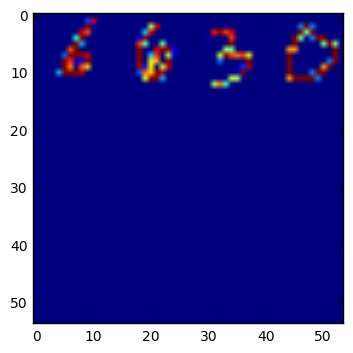

array([ 6,  6,  3,  0, 10,  4])

In [105]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_image_real[500]))
plt.imshow(im)
plt.show()

train_label_real[500]

In [4]:
# Normalize images 
test_images = (test_image_real - float(128))/float(128)
train_images = (train_image_real[:20000] - float(128))/float(128)

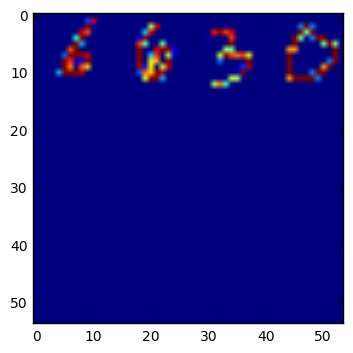

array([ 6,  6,  3,  0, 10,  4])

In [107]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_images[500] * 128 +128))
plt.imshow(im)
plt.show()

train_label_real[500]

In [5]:
train_labels_enc = hp.one_hot_encode_labels(train_label_real[:20000])
test_labels_enc = hp.one_hot_encode_labels(test_label_real)

In [9]:
test_images = test_images.reshape(10000, 54,54,1)
train_images = train_images.reshape(20000, 54,54,1)

In [10]:
y1 = train_labels_enc[:,0,:]
y2 = train_labels_enc[:,1,:]
y3 = train_labels_enc[:,2,:]
y4 = train_labels_enc[:,3,:]
y5 = train_labels_enc[:,4,:]
y_seq_len = train_labels_enc[:,5,:]

y_labels = [y_seq_len, y1, y2, y3, y4, y5]

vy1 = test_labels_enc[:,0,:]
vy2 = test_labels_enc[:,1,:]
vy3 = test_labels_enc[:,2,:]
vy4 = test_labels_enc[:,3,:]
vy5 = test_labels_enc[:,4,:]
vy_seq_len = test_labels_enc[:,5,:] 

y_seq_len_trunc = y_seq_len[:,1:6]
vy_seq_len_trunc = vy_seq_len[:,1:6]


vx = test_images
validation_data = (vx, [vy_seq_len_trunc, vy1, vy2, vy3, vy4, vy5])


#### Model

In [11]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, LocallyConnected2D
from keras.models import Model
from keras.optimizers import SGD

# this returns a tensor
inputs = Input(shape=(54, 54, 1))


# x = Dense(64, init='normal', input_dim=8192, activation='relu',  W_regularizer='l1')(inputs)

x = Convolution2D(48, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5, init='normal', border_mode='same',  W_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(160, 5, 5, init='normal', border_mode='same',  W_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)
x = Flatten()(inputs)

x = Dense(3072, init='normal', W_regularizer='l1') (x)
x = Dropout(0.25)(x)

x = Dense(3072, init='normal', W_regularizer='l1') (x)
x = Dropout(0.25)(x)

# Keras layers can be called on TensorFlow tensors:
d1 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d2 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d3 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d4 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d5 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d_len = Dense(5, init='normal', activation='softmax', W_regularizer='l1')(x)

outputs = [d_len, d1, d2, d3, d4, d5]

sgd = SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=outputs)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


In [1]:
data = train_images
labels = [y_seq_len_trunc, y1, y2, y3, y4, y5]
model.fit(data, labels, batch_size=50, nb_epoch=15, validation_data = validation_data)  # starts training

NameError: name 'train_images' is not defined

In [41]:
def compute_overall_accuracy(images, labels, model, verbose=False):
    preds = model.predict(images)
    predictions = []
    for output in preds:
        predictions.append(np.argmax(output, axis = 1))
    correct_predictions = 0
    for i, label in enumerate(labels):
        seq_len = label[5]
        if seq_len == (predictions[0][i] + 1):
            for j in range(int(seq_len)):
                if (predictions[j+1][i] != label[j]):
                    continue
                if j == seq_len - 1:
                    correct_predictions += 1
    if verbose == True:
        print ("The number of correct predictions is %d from a total of %d")%(correct_predictions, len(images))
    acc = float(correct_predictions) / len(images)
    return acc

In [14]:
compute_overall_accuracy(test_images,test_label_real,model)

0.6148

### Question 1
_What approach did you take in coming up with a solution to this problem?_

Untitled script**Answer:** 

For this problem I started by reading the Goodfellow paper on this particular problem. From there I decided to use convolution layers and then fully connected layers to solve this problem. To understand the problem better I consulted the forums often to find answers to common problems I shared with other students.

I followed an iterative process my understanding improved with every iteration:
 * 1: [paper] First I started by reading the paper and I got an overview of what to expect and how should I approach 
 * 2: [forums]: The paper was not enough to get me started on the project. From the forums I started to understand how different student were handling the first part of the problem which is generating the Synthetic dataset. From there I was able to achieve this part of the project
 * 3: [paper]: going back to the paper I revisted the part where the preprocessing of the SVHN dataset is discussed.
 * 4: [forums]: Next, from the forums I gathered information on how different people are dealing with this part and how are they diverging or converging with the paper. After this step I was able to implement my own SVHN preprocessing version.
 * 5: [forums]: Now that my synthetic dataset is ready, and SVHN data preprocessed, I went back to the forums to understand some key parts of the paper where people where discussing the ideas in details. From the discussions I moved from a theoretical understanding of the solution to actually starting and coding the solution.
 * 6: [paper]: After spending sometime experimenting with the synthetic and SVHN dataset using different models. I decided to revisit the paper for another round now that my understanding of the problem is much more advanced and hands on. The aim of this round was to confirm that what I understood from the forums and what I implemented is inline with what was being implemented in the paper
 * 7: [forums]: After I finished my model I revisted the forums to know how to deal with the bounding boxes part and how different people are implementing the different part of this project.

First of all I started by generating the synthetic data set. This in itself was a big task for someone who never dealt with any image processing in programming. So part of the challenge was to understand how to build the synthetic dataset from the individual digits we have.
The next step was building a simple model just to make sure everything is working and then I started making it more and more complex. Here I switched between tensorflow then keras then tried a hybrid model with both and ended up using keras alone. It was a struggle to find out where the model went wrong because of the many parameters to tune that might go wrong.

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

My model is an edited version of Goodfellow where it is made up of a series of convolution layers and connected to 2 fully connected layers at the end. In particular, it is build as follows:

* Convolution(48) --> maxpooling --> Dropout --> Relu
* Convolution(64) --> maxpooling --> Dropout --> Relu
* Convolution(128) --> maxpooling --> Dropout --> Relu
* Convolution(160) --> maxpooling --> Dropout --> Relu
* Convolution(192) --> maxpooling --> Dropout --> Relu
* Convolution(192) --> maxpooling --> Dropout --> Relu
* Convolution(192) --> maxpooling --> Dropout --> Relu
* Flatten()
* Fully connected(3072) --> Dropout
* Fully connected(3072) --> Dropout

Then for each digit seperate there is a fully connected layer with softmax
* digit1: Fully connected(11) --> Softmax
* digit2: Fully connected(11) --> Softmax
* digit3: Fully connected(11) --> Softmax
* digit4: Fully connected(11) --> Softmax
* digit5: Fully connected(11) --> Softmax
* sequence length : Fully connected(5) --> Softmax

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

** How did you train your model? **
The model was trained by reducing the loss from each digit and digit length altogether using stochastic gradient descent with a learning rate of 0.01


** How did you generate your synthetic dataset? ** To generate the dataset I followed the following approach:
* for each image in the MNIST dataset, generate a random number between 1 and 5 which will be used as the sequence length
* Append images randomly from the dataset of the current image until I match the sequnce length generated
* Resize the image produced to 54 x 54 size
* Example of the images produced are found in the code blocks above

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preparing the data

In [ ]:
hp.untar_svhn(dataset = "training", path="./SVHN_data/")
hp.untar_svhn(dataset = "testing", path="./SVHN_data/")

In [ ]:
test_images_info = hp.read_process_h5('./SVHN_data/test/digitStruct.mat')
print test_images_info[2]

In [ ]:
train_images_info = hp.read_process_h5('./SVHN_data/train/digitStruct.mat')
print train_images_info[2]

In [ ]:
hp.process_all_images('./SVHN_data/test/','./SVHN_data/test_proc/',test_images_info)

In [ ]:
hp.process_all_images('./SVHN_data/train/','./SVHN_data/train_proc/',train_images_info)

In [ ]:
def prepare_svhn_data_for_tf(path,info):
    images_list = os.listdir(path)
    png = []
    labels = []
    for image in images_list:
        read_image = misc.imread(path+image)
        image_np = np.asarray(read_image)
        image_np = np.concatenate(np.concatenate(image_np))
        png.append(image_np)   
        
        image_num = int(image[:-4]) - 1
        image_label = info[image_num]['labels']
        image_length = info[image_num]['length']
        if image_length >5:
            image_label = image_label[:5]
        for i in range(image_length, 5):
            image_label = np.append(image_label,0)
        image_label = np.append(image_label,image_length)
        labels.append(image_label)
        
    images = np.asarray(png,dtype=np.uint16)
    labels =  np.asarray(labels)
    return images, labels

In [ ]:
test_image_real, test_label_real = prepare_svhn_data_for_tf('./SVHN_data/test_proc/',test_images_info)

In [ ]:
train_image_real, train_label_real = prepare_svhn_data_for_tf('./SVHN_data/train_proc/',train_images_info)

In [ ]:
all_data_dict = {'train_images' : train_image_real,
                 'train_labels' : train_label_real,
                 'test_images': test_image_real,
                 'test_labels': test_label_real }

with open('./SVHN_data/train_test_data.p', 'wb') as handle:
    pkl.dump(all_data_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

#### Reading the generated data

In [43]:
train_test_data = pkl.load(open('./SVHN_data/train_test_data.p', "rb"))

In [44]:
print train_test_data.keys()
train_label_real = train_test_data['train_labels']
test_label_real = train_test_data['test_labels']
train_image_real = train_test_data['train_images']
test_image_real = train_test_data['test_images']
print train_image_real.shape

['train_labels', 'test_labels', 'train_images', 'test_images']
(33402, 8748)


In [45]:
train_image_real = train_image_real.reshape(len(train_image_real), 54,54,3)
test_image_real = test_image_real.reshape(len(test_image_real), 54,54,3)

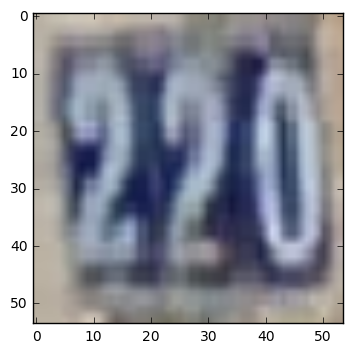

array([  2.,   2.,  10.,   0.,   0.,   3.])

In [5]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_image_real[500]))
plt.imshow(im)
plt.show()

train_label_real[500]

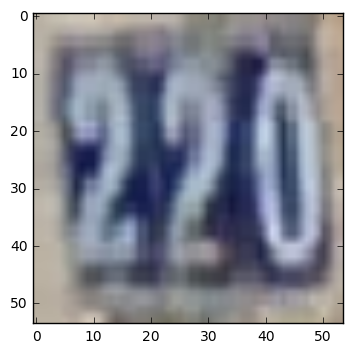

array([  2.,   2.,  10.,   0.,   0.,   3.])

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
im = Image.fromarray(np.uint8(train_images[500] * 128 +128))
plt.imshow(im)
plt.show()

train_label_real[500]

In [46]:
from PIL import Image
def covert_to_greyscale(images):
    converted_images = []
    for image in images:
        im = Image.fromarray(np.uint8(image)).convert('L')
        converted_images.append(np.array(im.getdata()))
    return np.asarray(converted_images)

In [47]:
train_image_real = covert_to_greyscale(train_image_real)

In [48]:
test_image_real = covert_to_greyscale(test_image_real)

In [57]:
# Normalize images 
test_images = (test_image_real - float(128))/float(128)
train_images_1 = (train_image_real[:5000] - float(128))/float(128)
train_images_2 = (train_image_real[5000:10000] - float(128))/float(128)
train_images_3 = (train_image_real[10000:15000] - float(128))/float(128)
train_images_4 = (train_image_real[15000:20000] - float(128))/float(128)
train_images = np.concatenate([train_images_1,train_images_2, train_images_3, train_images_4], axis=0)
print train_images.shape

(20000, 2916)


In [58]:
print np.max(train_images)
print np.max(test_images)

0.9921875
0.9921875


In [59]:
test_images = test_images.reshape(13068,54,54,1)
train_images = train_images.reshape(20000,54,54,1)

In [60]:
train_labels_enc = hp.one_hot_encode_labels(train_label_real[:20000])
test_labels_enc = hp.one_hot_encode_labels(test_label_real)

In [61]:
train_labels_enc[500]

array([[ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [62]:
y1 = train_labels_enc[:,0,:]
y2 = train_labels_enc[:,1,:]
y3 = train_labels_enc[:,2,:]
y4 = train_labels_enc[:,3,:]
y5 = train_labels_enc[:,4,:]
y_seq_len = train_labels_enc[:,5,:]
y_seq_len_trunc = y_seq_len[:,1:6]

vy1 = test_labels_enc[:,0,:]
vy2 = test_labels_enc[:,1,:]
vy3 = test_labels_enc[:,2,:]
vy4 = test_labels_enc[:,3,:]
vy5 = test_labels_enc[:,4,:]
vy_seq_len = test_labels_enc[:,5,:] 
vy_seq_len_trunc = vy_seq_len[:,1:6]

vx = test_images
validation_data = (vx, [vy_seq_len_trunc, vy1, vy2, vy3, vy4, vy5])


#### Same as synthetic model (5 epochs)

In [13]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, LocallyConnected2D
from keras.models import Model
from keras.optimizers import SGD

# this returns a tensor
inputs = Input(shape=(54, 54, 1))


# x = Dense(64, init='normal', input_dim=8192, activation='relu',  W_regularizer='l1')(inputs)

x = Convolution2D(48, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5, init='normal', border_mode='same',  W_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(160, 5, 5, init='normal', border_mode='same',  W_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.25)(x)
x = Activation('relu')(x)
x = Flatten()(inputs)

x = Dense(3072, init='normal', W_regularizer='l1') (x)
x = Dropout(0.25)(x)

x = Dense(3072, init='normal', W_regularizer='l1') (x)
x = Dropout(0.25)(x)

# Keras layers can be called on TensorFlow tensors:
d1 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d2 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d3 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d4 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d5 = Dense(11, init='normal', activation='softmax', W_regularizer='l1')(x)
d_len = Dense(5, init='normal', activation='softmax', W_regularizer='l1')(x)

outputs = [d_len, d1, d2, d3, d4, d5]

sgd = SGD(lr=0.0001, momentum=0.9, decay=0.0, nesterov=False)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=outputs)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.


In [14]:
data = train_images
labels = [y_seq_len_trunc, y1, y2, y3, y4, y5]
model.fit(data, labels, batch_size=50, nb_epoch=5, validation_data = validation_data)  # starts training

Train on 20000 samples, validate on 13068 samples
Epoch 1/5
20000/20000 [==============================] - 353s - loss: 7105.8130 - dense_8_loss: 5.7202 - dense_3_loss: 8.5387 - dense_4_loss: 8.8534 - dense_5_loss: 6.6306 - dense_6_loss: 5.4874 - dense_7_loss: 4.8878 - dense_8_acc: 0.3559 - dense_3_acc: 0.1435 - dense_4_acc: 0.1137 - dense_5_acc: 0.4139 - dense_6_acc: 0.5958 - dense_7_acc: 0.6415 - val_loss: 6728.8591 - val_dense_8_loss: 2.0197 - val_dense_3_loss: 4.2879 - val_dense_4_loss: 4.3921 - val_dense_5_loss: 2.9404 - val_dense_6_loss: 4.0052 - val_dense_7_loss: 3.8668 - val_dense_8_acc: 0.4703 - val_dense_3_acc: 0.1935 - val_dense_4_acc: 0.1585 - val_dense_5_acc: 0.5569 - val_dense_6_acc: 0.6358 - val_dense_7_acc: 0.6345
Epoch 2/5
20000/20000 [==============================] - 348s - loss: 6386.8574 - dense_8_loss: 2.9752 - dense_3_loss: 5.1510 - dense_4_loss: 5.7780 - dense_5_loss: 3.6374 - dense_6_loss: 1.8898 - dense_7_loss: 1.4766 - dense_8_acc: 0.4112 - dense_3_acc: 0.181

In [16]:
compute_overall_accuracy(test_images,test_label_real,model)

0.05456075910621365

#### Improved Model (5 epochs)

In [28]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, LocallyConnected2D
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam

# this returns a tensor
inputs = Input(shape=(54, 54, 1))


# x = Dense(64, init='normal', input_dim=8192, activation='relu',  W_regularizer='l1')(inputs)

x = Convolution2D(48, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(160, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Flatten()(inputs)

x = Dense(2048, init='normal', W_regularizer='l1l2', b_regularizer='l1') (x)
x = Dropout(0.5)(x)

x = Dense(2048, init='normal', W_regularizer='l1l2', b_regularizer='l1') (x)
x = Dropout(0.5)(x)

# Keras layers can be called on TensorFlow tensors:
d1 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d2 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d3 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d4 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d5 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d_len = Dense(5, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)

outputs = [d_len, d1, d2, d3, d4, d5]


learning_rate = 0.00001
adam = Adam(lr=learning_rate)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=outputs)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
data = train_images
labels = [y_seq_len_trunc, y1, y2, y3, y4, y5]
model.fit(data, labels, batch_size=50, nb_epoch=5, validation_data = validation_data)  # starts training

Train on 20000 samples, validate on 13068 samples
Epoch 1/5
20000/20000 [==============================] - 276s - loss: 4319.3064 - dense_40_loss: 7.6075 - dense_35_loss: 10.4915 - dense_36_loss: 10.7856 - dense_37_loss: 7.8394 - dense_38_loss: 6.1009 - dense_39_loss: 5.7629 - dense_40_acc: 0.2902 - dense_35_acc: 0.1228 - dense_36_acc: 0.0959 - dense_37_acc: 0.3925 - dense_38_acc: 0.5306 - dense_39_acc: 0.5596 - val_loss: 4208.6364 - val_dense_40_loss: 5.4589 - val_dense_35_loss: 7.2739 - val_dense_36_loss: 5.7163 - val_dense_37_loss: 6.3705 - val_dense_38_loss: 5.4311 - val_dense_39_loss: 5.4756 - val_dense_40_acc: 0.4255 - val_dense_35_acc: 0.1806 - val_dense_36_acc: 0.1384 - val_dense_37_acc: 0.4871 - val_dense_38_acc: 0.5937 - val_dense_39_acc: 0.5980
Epoch 2/5
20000/20000 [==============================] - 272s - loss: 4119.3301 - dense_40_loss: 6.6596 - dense_35_loss: 9.5196 - dense_36_loss: 9.8191 - dense_37_loss: 7.3330 - dense_38_loss: 5.4902 - dense_39_loss: 5.1303 - dense_40

In [30]:
compute_overall_accuracy(test_images,test_label_real,model)

0.047520661157024795

In [36]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, LocallyConnected2D
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam

# this returns a tensor
inputs = Input(shape=(54, 54, 1))


# x = Dense(64, init='normal', input_dim=8192, activation='relu',  W_regularizer='l1')(inputs)

x = Convolution2D(48, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(160, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Flatten()(inputs)

x = Dense(2048, init='normal', W_regularizer='l1l2', b_regularizer='l1') (x)
x = Dropout(0.5)(x)

x = Dense(2048, init='normal', W_regularizer='l1l2', b_regularizer='l1') (x)
x = Dropout(0.5)(x)

# Keras layers can be called on TensorFlow tensors:
d1 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d2 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d3 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d4 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d5 = Dense(11, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)
d_len = Dense(5, init='normal', activation='softmax', W_regularizer='l1l2', b_regularizer='l1')(x)

outputs = [d_len, d1, d2, d3, d4, d5]


learning_rate = 0.00001
adam = Adam(lr=learning_rate)

# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=outputs)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
data = train_images
labels = [y_seq_len_trunc, y1, y2, y3, y4, y5]
model.fit(data, labels, batch_size=50, nb_epoch=15, validation_data = validation_data)  # starts training

Train on 20000 samples, validate on 13068 samples
Epoch 1/15
20000/20000 [==============================] - 430s - loss: 4318.5346 - dense_48_loss: 7.5026 - dense_43_loss: 10.5000 - dense_44_loss: 10.7239 - dense_45_loss: 7.8452 - dense_46_loss: 6.2501 - dense_47_loss: 5.7766 - dense_48_acc: 0.3012 - dense_43_acc: 0.1165 - dense_44_acc: 0.0952 - dense_45_acc: 0.3890 - dense_46_acc: 0.5279 - dense_47_acc: 0.5591 - val_loss: 4206.4403 - val_dense_48_loss: 4.8897 - val_dense_43_loss: 6.7051 - val_dense_44_loss: 4.9381 - val_dense_45_loss: 6.2050 - val_dense_46_loss: 5.5460 - val_dense_47_loss: 5.4029 - val_dense_48_acc: 0.4060 - val_dense_43_acc: 0.1754 - val_dense_44_acc: 0.1282 - val_dense_45_acc: 0.4907 - val_dense_46_acc: 0.5898 - val_dense_47_acc: 0.6042
Epoch 2/15
20000/20000 [==============================] - 410s - loss: 4119.8866 - dense_48_loss: 6.6963 - dense_43_loss: 9.4797 - dense_44_loss: 9.7807 - dense_45_loss: 7.2454 - dense_46_loss: 5.6412 - dense_47_loss: 5.1089 - dense_

In [63]:
compute_overall_accuracy(test_images,test_label_real,model, verbose=True)

The number of correct predictions is 662 from a total of 13068


0.05065809611264157

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

The preprocessing of the SVHN dataset was done as follows:
* For each image I extracted the bounding box information for each digit to build 1 bounding box that encapsulate the whole sequence
* Each image was cropped around this rounding box (I did not crop at bounding box plus 30% like the Goodfellow paper)
* The newly generated set of images was saved for ease of access and better understanding
* Then the new images and there labels were read into numpy arrays.
* The images were converted to Grey scale to reduced to grey scale because color should not be a factor in recognizing digits
* The images was normalized by their mean.

I trained on 20000 samples from the SVHN training set and tested on 13068 from the testing set. 
Having a bigger dataset and using the extra dataset can help improve our results. But due to limilations in my computer hardware even training of the whole training dataset which is around 33401 samples was not possible and I had to go down to 20000 samples.

The accuracy of the model dropped significantly where applied to the realistic data set where it went down from XXX to XXX as can be seen above.

The accuracy of the predictions for each digit and digit length differs widely.
* The 3 last digits have good accuracy because most of the times they are blank so the classifier can achieve high accuracy by prediciting blanks
* Our model is also doing a fair job predicting length sequence. This is because the length sequence has only 5 choices instead of the 11 choices for each digit. Thus better results are expected.
* The bottleneck comes from the first 2 digits where the accuracy is still low.

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

To improve the results I did the following hyper parameter tuning to the model. Unfortunately, whatever I tried, it did not help my model improve. And due to the hardware limitations on my machine, changing and testing is exteremely time consuming and thus trying a large amount of changes was not feasible.
* Regularizations
    * I have changed all weights regularizations from l1 to l1l2. 
    * I have added regularization to the bias 
* Optimizers:
    * I have tried the SGD
    * I have tired the RMSprop optimizer
    * I have tried the Adam optimizer
* Learning rates:
    * I have tried to use a higher learning rate (0.001, 0.0005, 0.0002)
    * I have tried to lower the learning rate to 0.00001
    * I have tried to create a linear learning decay function
* Layers:
    * Change the last layer to 4048
    * Change the last layer to 2048
    
All the above, did not make my model predict better results.

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**


The initial results of the model using the Synthetic dataset model with 5 epochs are:
* Sequence length accuracy: 0.6059
* Digit 1 accuracy: 0.2723
* Digit 2 accuracy: 0.1697
* Digit 3 accuracy: 0.8258
* Digit 4 accuracy: 0.9885
* Digit 5 accuracy: 0.9998
* **Overall accuracy: 0.05456**

The results of the model final model but with 15 epochs:
* Sequence length accuracy: 0.6188
* Digit 1 accuracy: 0.2761
* Digit 2 accuracy: 0.1592
* Digit 3 accuracy: 0.8270
* Digit 4 accuracy: 0.9878
* Digit 5 accuracy: 0.9995
* **Overall accuracy: 0.05066**


My model is definetly not prediciting good results

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

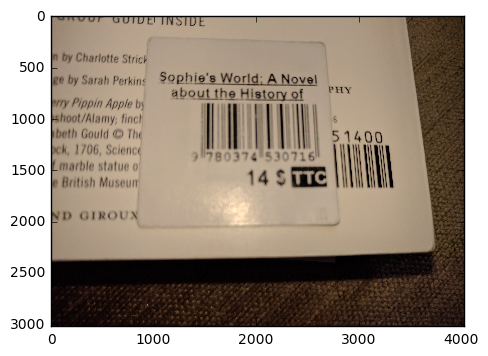

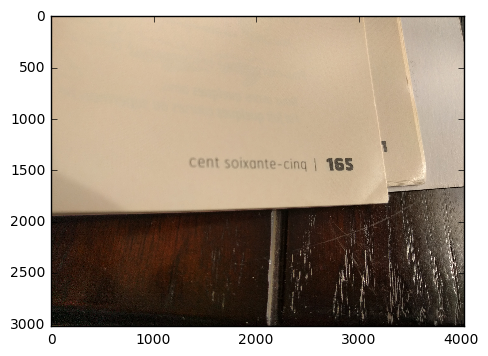

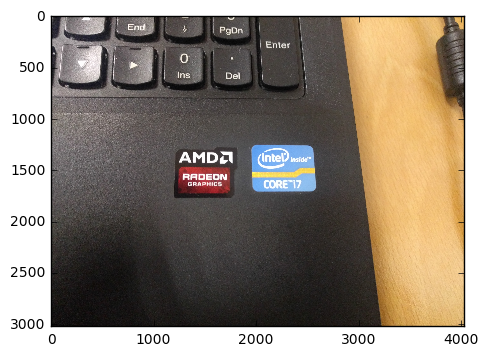

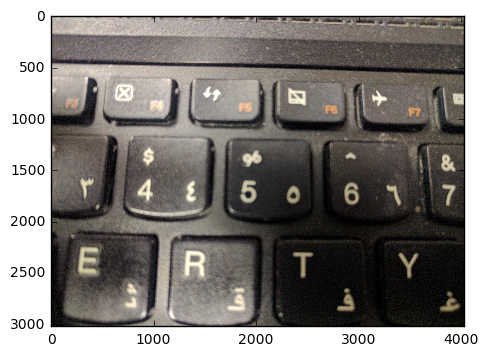

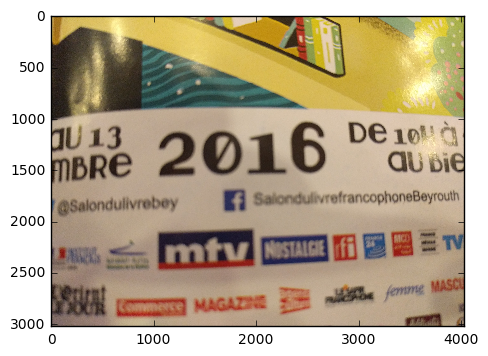

In [110]:
# Images as taken from my phones camera
from PIL import Image
import matplotlib.pyplot as plt
first_image = Image.open('./captured_images/pic_14_org.jpg')
second_image = Image.open('./captured_images/pic_165_org.jpg')
third_image = Image.open('./captured_images/pic_7_org.jpg')
fourth_image = Image.open('./captured_images/pic_5_org.jpg')
fifth_image = Image.open('./captured_images/pic_2016_org.jpg')
plt.imshow(first_image)
plt.figure(2)
plt.imshow(second_image)
plt.figure(3)
plt.imshow(third_image)
plt.figure(4)
plt.imshow(fourth_image)
plt.figure(5)
plt.imshow(fifth_image)
plt.show()

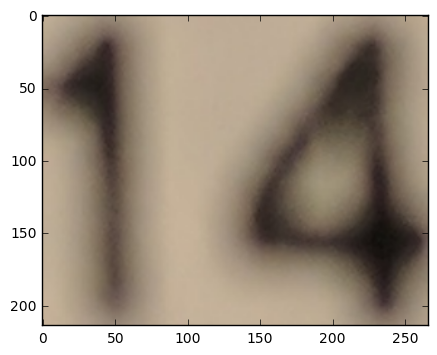

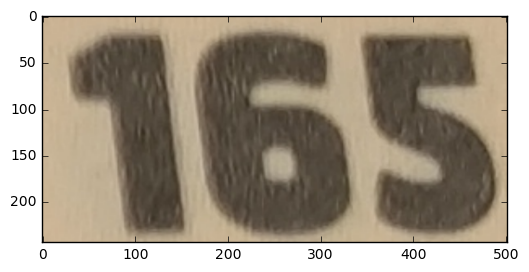

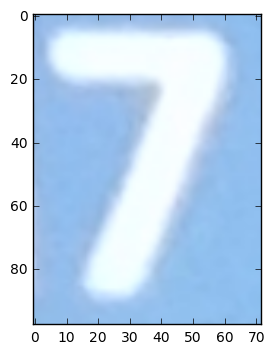

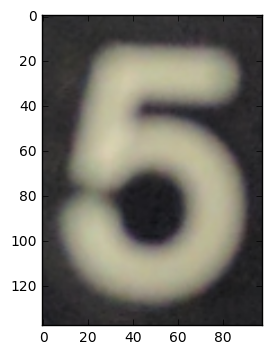

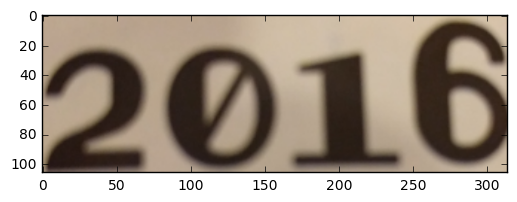

In [107]:
# After cropping the images to keep the numbers only
from PIL import Image
import matplotlib.pyplot as plt
first_image = Image.open('./captured_images/pic_14.png')
second_image = Image.open('./captured_images/pic_165.png')
third_image = Image.open('./captured_images/pic_7.png')
fourth_image = Image.open('./captured_images/pic_5.png')
fifth_image = Image.open('./captured_images/pic_2016.png')
plt.imshow(first_image)
plt.figure(2)
plt.imshow(second_image)
plt.figure(3)
plt.imshow(third_image)
plt.figure(4)
plt.imshow(fourth_image)
plt.figure(5)
plt.imshow(fifth_image)
plt.show()

In [45]:
from PIL import Image
first_image = Image.open('./captured_images/pic_14.png').convert('L')
resized = first_image.resize((54, 54))
resized.save('./captured_images/pic_14_resized.png')

second_image = Image.open('./captured_images/pic_165.png').convert('L')
resized = second_image.resize((54, 54))
resized.save('./captured_images/pic_165_resized.png')

third_image = Image.open('./captured_images/pic_7.png').convert('L')
resized = second_image.resize((54, 54))
resized.save('./captured_images/pic_7_resized.png')

fourth_image = Image.open('./captured_images/pic_5.png').convert('L')
resized = second_image.resize((54, 54))
resized.save('./captured_images/pic_5_resized.png')

fifth_image = Image.open('./captured_images/pic_2016.png').convert('L')
resized = second_image.resize((54, 54))
resized.save('./captured_images/pic_2016_resized.png')

In [64]:
from scipy import misc
first_image_resized = misc.imread("./captured_images/pic_14_resized.png")
second_image_resized = misc.imread("./captured_images/pic_165_resized.png")
third_image_resized = misc.imread("./captured_images/pic_7_resized.png")
fourth_image_resized = misc.imread("./captured_images/pic_5_resized.png")
fifth_image_resized = misc.imread("./captured_images/pic_2016_resized.png")

print first_image_resized.shape
print second_image_resized.shape
print third_image_resized.shape
print fourth_image_resized.shape
print fifth_image_resized.shape

(54, 54)
(54, 54)
(54, 54)
(54, 54)
(54, 54)


In [65]:
first_image_resized = first_image_resized.reshape(54,54,1)
second_image_resized = second_image_resized.reshape(54,54,1)
third_image_resized = third_image_resized.reshape(54,54,1)
fourth_image_resized = fourth_image_resized.reshape(54,54,1)
fifth_image_resized = fifth_image_resized.reshape(54,54,1)

captured = np.asarray([first_image_resized, second_image_resized,
                      third_image_resized, fourth_image_resized,
                      fifth_image_resized])

In [66]:
# Each column in the predictions produced is a digit predictions [length, 1st, 2nd, 3rd, 4th, 5th]
# first pic correct value is [1,1,4,0,0,0]
# second pic correct value is [2,1,6,5,0,0]
# third pic correct value is [0,7,0,0,0,0]
# fourth pic correct value is [0,5,0,0,0,0]
# fifth pic correct value is [3,2,10,1,6,0]
preds = model.predict(captured)
for pred in preds:
    print np.argmax(pred, axis=1)

[4 2 2 2 2]
[1 0 0 0 0]
[4 6 6 6 6]
[1 9 9 9 9]
[7 1 1 1 1]
[8 5 5 5 5]


### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

* The images I chose have a variety of size. 2 1-digit, 1 2-digits, 1 3-digits and 1 4-digits sequences
* Different fonts are used for each image
* A variety of background colors and digit colors are used in the images
* Some of the images are more blurred than others

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

On the captured imags the performace on the captured set is as follows:
* Sequence length accuracy: --> only second pic correct --> 1/5 --> 0.2
* Digit 1 accuracy: --> only first pic correct --> 1/5 --> 0.2
* Digit 2 accuracy: --> only first pic correct --> 1/5 --> 0.2
* Digit 3 accuracy: --> First and second pic correct --> 2/5 --> 0.4
* Digit 4 accuracy: --> zero correct predictions --> 0/5 --> 0
* Digit 5 accuracy: --> zero correct predictions --> 0/5 --> 0
* **Overall accuracy: 0 **

We can see that our model did not produce any correct result on the captured images compared to th 5% correct rate on the SVHN dataset. It is to be noted that digits 4 and 5 which had a high accuracy on the validation dataset did not produce the same behavior on the captured data set with zero correct predictions.
A lot of the predictions are the same for the different images which indicates that our model is generalizing the data a lot. This could be a sign of underfitting.

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

#### Preparing the data

In [21]:
test_images_info = hp.read_process_h5('./SVHN_data/test/digitStruct.mat')

In [22]:
train_images_info = hp.read_process_h5('./SVHN_data/train/digitStruct.mat')

In [27]:
import os
def process_all_images(source_folder, destination_folder, images_info):
    images_list = os.listdir(source_folder)
    images_list.remove('digitStruct.mat')
    images_list.remove('see_bboxes.m')
    digits = [{'top': [], 'bottom': [], 'left':[],'right':[]},
              {'top': [], 'bottom': [], 'left':[],'right':[]},
              {'top': [], 'bottom': [], 'left':[],'right':[]},
              {'top': [], 'bottom': [], 'left':[],'right':[]},
              {'top': [], 'bottom': [], 'left':[],'right':[]}]
    
    images = []
    for image_name in images_list:
        image_num = int(image_name[:-4]) - 1
        original = Image.open(source_folder + image_name)
        width, height = original.size
        seq_len = images_info[image_num]['length']
        if seq_len > 5:
            continue
        for j in range(seq_len):
            top = images_info[image_num]['top'][j]
            bottom = images_info[image_num]['top'][j] + images_info[image_num]['height'][j]
            left = images_info[image_num]['left'][j]
            right = images_info[image_num]['left'][j] + images_info[image_num]['width'][j]

            digits[j]['top'].append(float(top)/ height)
            digits[j]['bottom'].append(float(bottom)/height)
            digits[j]['left'].append(float(left)/width)
            digits[j]['right'].append(float(right)/width)
        for k in range(seq_len,5):
            digits[k]['top'].append(0.0)
            digits[k]['bottom'].append(0.0)
            digits[k]['left'].append(0.0)
            digits[k]['right'].append(0.0)
        
        original = Image.open(source_folder + image_name)
        new_image = original.resize((54,54)).convert('L')
        new_image.save(destination_folder + image_name)
        image_array = np.array(new_image)
        images.append(image_array)
    for m, digit in enumerate(digits):
        digits[m]['top'] = np.asarray(digit['top'])
        digits[m]['bottom'] = np.asarray(digit['bottom'])
        digits[m]['left'] = np.asarray(digit['left'])
        digits[m]['right'] = np.asarray(digit['right'])
    return digits, np.asarray(images)

In [28]:
test_digits, test_images = process_all_images('./SVHN_data/test/','./SVHN_data/test_bboxes/',test_images_info)

In [30]:
train_digits, train_images = process_all_images('./SVHN_data/train/','./SVHN_data/train_bboxes/',train_images_info)

In [31]:
all_data_dict = {'train_images' : train_images,
                 'train_labels' : train_digits,
                 'test_images': test_images,
                 'test_labels': test_digits }

with open('./SVHN_data/bboxes_train_test_data.p', 'wb') as handle:
    pkl.dump(all_data_dict, handle, protocol=pkl.HIGHEST_PROTOCOL)

#### Read the processed data

In [2]:
train_test_data = pkl.load(open('./SVHN_data/bboxes_train_test_data.p', "rb"))

In [33]:
print train_test_data.keys()
train_digits = train_test_data['train_labels']
test_digits = train_test_data['test_labels']
train_images = train_test_data['train_images']
test_images = train_test_data['test_images']
print train_images.shape

['train_labels', 'test_labels', 'train_images', 'test_images']
(33401, 54, 54)


In [32]:
for i in train_digits:
    print np.max(i['top'])
    print np.max(i['bottom'])
    print np.max(i['left'])
    print np.max(i['right'])
    print
    print np.min(i['top'])
    print np.min(i['bottom'])
    print np.min(i['left'])
    print np.min(i['right'])
    print

0.89898989899
1.38461538462
0.886363636364
1.0

0.0
0.181818181818
-0.0285714285714
0.0235294117647

0.794117647059
1.075
0.94696969697
1.02857142857

0.0
0.0
0.0
0.0

0.833333333333
1.125
0.924528301887
1.00609756098

0.0
0.0
0.0
0.0

0.776470588235
1.07142857143
0.880530973451
0.986394557823

0.0
0.0
0.0
0.0

0.444444444444
0.95
0.657142857143
0.8

0.0
0.0
0.0
0.0



In [34]:
test_images_norm = (test_images - float(128))/float(128)
train_images_norm = (train_images - float(128))/float(128)

In [53]:
test_images_norm = test_images_norm.reshape(len(test_images_norm),54,54,1)
train_images_norm = train_images_norm.reshape(len(train_images_norm),54,54,1)

In [61]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, Dropout, Activation, Flatten, LocallyConnected2D
from keras.models import Model
from keras.optimizers import SGD, RMSprop, Adam

# this returns a tensor
inputs = Input(shape=(54, 54, 1))

# x = Dense(64, init='normal', input_dim=8192, activation='relu',  W_regularizer='l1')(inputs)

x = Convolution2D(48, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(64, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(128, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(160, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1' )(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)

x = Convolution2D(192, 5, 5, init='normal', border_mode='same',  W_regularizer='l1l2', b_regularizer='l1')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.5)(x)
x = Activation('relu')(x)
x = Flatten()(inputs)

x = Dense(2048, init='normal', W_regularizer='l1l2', b_regularizer='l1') (x)
x = Dropout(0.5)(x)

x = Dense(2048, init='normal', W_regularizer='l1l2', b_regularizer='l1') (x)
x = Dropout(0.5)(x)

x = Flatten()(inputs)

x = Dense(4048, init='normal', W_regularizer='l1l2') (x)
x = Dropout(0.25)(x)

x = Dense(4048, init='normal', W_regularizer='l1l2') (x)
x = Dropout(0.25)(x)


top1 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
bottom1 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
left1 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
right1 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)

top2 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
bottom2 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
left2 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
right2 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)

top3 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
bottom3 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
left3 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
right3 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)

top4 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
bottom4 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
left4 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
right4 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)

top5 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
bottom5 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
left5 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)
right5 = Dense(1, init='zero', activation='linear', W_regularizer='l1l2', b_regularizer='l1')(x)

output = [top1, bottom1, left1, right1,
         top2, bottom2, left2, right2,
         top3, bottom3, left3, right3,
         top4, bottom4, left4, right4]

learning_rate = 0.00001
adam = Adam(lr=learning_rate)


# this creates a model that includes
# the Input layer and three Dense layers
model = Model(input=inputs, output=output)
model.compile(optimizer=adam,
              loss='mean_squared_error',
              metrics=['mean_squared_error'])

In [62]:
outputs = [train_digits[0]['top'],train_digits[0]['bottom'],train_digits[0]['left'],train_digits[0]['right'],
           train_digits[1]['top'],train_digits[1]['bottom'],train_digits[1]['left'],train_digits[1]['right'],
           train_digits[2]['top'],train_digits[2]['bottom'],train_digits[2]['left'],train_digits[2]['right'],
           train_digits[3]['top'],train_digits[3]['bottom'],train_digits[3]['left'],train_digits[3]['right']]

v_outputs = [test_digits[0]['top'],test_digits[0]['bottom'],test_digits[0]['left'],test_digits[0]['right'],
           test_digits[1]['top'],test_digits[1]['bottom'],test_digits[1]['left'],test_digits[1]['right'],
           test_digits[2]['top'],test_digits[2]['bottom'],test_digits[2]['left'],test_digits[2]['right'],
           test_digits[3]['top'],test_digits[3]['bottom'],test_digits[3]['left'],test_digits[3]['right']]
validation_data = (test_images_norm, v_outputs)
model.fit(train_images_norm, outputs, batch_size=50, nb_epoch=15, validation_data = validation_data)  # starts training

Train on 33401 samples, validate on 13068 samples
Epoch 1/15
33401/33401 [==============================] - 1425s - loss: 10980.3123 - dense_29_loss: 0.2212 - dense_30_loss: 1.7952 - dense_31_loss: 0.3947 - dense_32_loss: 0.6742 - dense_33_loss: 0.1881 - dense_34_loss: 1.5361 - dense_35_loss: 0.5921 - dense_36_loss: 0.9117 - dense_37_loss: 0.1083 - dense_38_loss: 0.6108 - dense_39_loss: 0.3853 - dense_40_loss: 0.5370 - dense_41_loss: 0.0129 - dense_42_loss: 0.0630 - dense_43_loss: 0.0498 - dense_44_loss: 0.0677 - dense_29_mean_squared_error: 0.2212 - dense_30_mean_squared_error: 1.7952 - dense_31_mean_squared_error: 0.3947 - dense_32_mean_squared_error: 0.6742 - dense_33_mean_squared_error: 0.1881 - dense_34_mean_squared_error: 1.5361 - dense_35_mean_squared_error: 0.5921 - dense_36_mean_squared_error: 0.9117 - dense_37_mean_squared_error: 0.1083 - dense_38_mean_squared_error: 0.6108 - dense_39_mean_squared_error: 0.3853 - dense_40_mean_squared_error: 0.5370 - dense_41_mean_squared_err

#### Captured dataset

In [137]:
from scipy import misc
first_image_resized = misc.imread("./captured_images/pic_14_resized.png")
second_image_resized = misc.imread("./captured_images/pic_165_resized.png")
third_image_resized = misc.imread("./captured_images/pic_7_resized.png")
fourth_image_resized = misc.imread("./captured_images/pic_5_resized.png")
fifth_image_resized = misc.imread("./captured_images/pic_2016_resized.png")

print first_image_resized.shape

(54, 54)


In [138]:
captured_digits = [{'top': [], 'bottom': [], 'left':[],'right':[]},
                   {'top': [], 'bottom': [], 'left':[],'right':[]},
                   {'top': [], 'bottom': [], 'left':[],'right':[]},
                   {'top': [], 'bottom': [], 'left':[],'right':[]},
                   {'top': [], 'bottom': [], 'left':[],'right':[]}]

# First image
original = Image.open('./captured_images/pic_14_resized.png')
width, height = original.size

captured_digits[0]['top'].append(float(2)/height)
captured_digits[1]['top'].append(float(1)/height)
captured_digits[2]['top'].append(float(0)/height)
captured_digits[3]['top'].append(float(0)/height)
captured_digits[4]['top'].append(float(0)/height)

captured_digits[0]['bottom'].append(float(204)/height)
captured_digits[1]['bottom'].append(float(204)/height)
captured_digits[2]['bottom'].append(float(0)/height)
captured_digits[3]['bottom'].append(float(0)/height)
captured_digits[4]['bottom'].append(float(0)/height)

captured_digits[0]['left'].append(float(1)/width)
captured_digits[1]['left'].append(float(140)/width)
captured_digits[2]['left'].append(float(0)/width)
captured_digits[3]['left'].append(float(0)/width)
captured_digits[4]['left'].append(float(0)/width)

captured_digits[0]['right'].append(float(58)/width)
captured_digits[1]['right'].append(float(264)/width)
captured_digits[2]['right'].append(float(0)/width)
captured_digits[3]['right'].append(float(0)/width)
captured_digits[4]['right'].append(float(0)/width)

#second Image
original = Image.open('./captured_images/pic_165_resized.png')
width, height = original.size

captured_digits[0]['top'].append(float(16)/height)
captured_digits[1]['top'].append(float(15)/height)
captured_digits[2]['top'].append(float(19)/height)
captured_digits[3]['top'].append(float(0)/height)
captured_digits[4]['top'].append(float(0)/height)

captured_digits[0]['bottom'].append(float(231)/height)
captured_digits[1]['bottom'].append(float(235)/height)
captured_digits[2]['bottom'].append(float(233)/height)
captured_digits[3]['bottom'].append(float(0)/height)
captured_digits[4]['bottom'].append(float(0)/height)

captured_digits[0]['left'].append(float(26)/width)
captured_digits[1]['left'].append(float(163)/width)
captured_digits[2]['left'].append(float(342)/width)
captured_digits[3]['left'].append(float(0)/width)
captured_digits[4]['left'].append(float(0)/width)

captured_digits[0]['right'].append(float(154)/width)
captured_digits[1]['right'].append(float(332)/width)
captured_digits[2]['right'].append(float(490)/width)
captured_digits[3]['right'].append(float(0)/width)
captured_digits[4]['right'].append(float(0)/width)

#third Image
original = Image.open('./captured_images/pic_7_resized.png')
width, height = original.size

captured_digits[0]['top'].append(float(14)/height)
captured_digits[1]['top'].append(float(0)/height)
captured_digits[2]['top'].append(float(0)/height)
captured_digits[3]['top'].append(float(0)/height)
captured_digits[4]['top'].append(float(0)/height)

captured_digits[0]['bottom'].append(float(130)/height)
captured_digits[1]['bottom'].append(float(0)/height)
captured_digits[2]['bottom'].append(float(0)/height)
captured_digits[3]['bottom'].append(float(0)/height)
captured_digits[4]['bottom'].append(float(0)/height)

captured_digits[0]['left'].append(float(6)/width)
captured_digits[1]['left'].append(float(0)/width)
captured_digits[2]['left'].append(float(0)/width)
captured_digits[3]['left'].append(float(0)/width)
captured_digits[4]['left'].append(float(0)/width)

captured_digits[0]['right'].append(float(90)/width)
captured_digits[1]['right'].append(float(0)/width)
captured_digits[2]['right'].append(float(0)/width)
captured_digits[3]['right'].append(float(0)/width)
captured_digits[4]['right'].append(float(0)/width)

#fourth Image
original = Image.open('./captured_images/pic_5_resized.png')
width, height = original.size

captured_digits[0]['top'].append(float(4)/height)
captured_digits[1]['top'].append(float(0)/height)
captured_digits[2]['top'].append(float(0)/height)
captured_digits[3]['top'].append(float(0)/height)
captured_digits[4]['top'].append(float(0)/height)

captured_digits[0]['bottom'].append(float(90)/height)
captured_digits[1]['bottom'].append(float(0)/height)
captured_digits[2]['bottom'].append(float(0)/height)
captured_digits[3]['bottom'].append(float(0)/height)
captured_digits[4]['bottom'].append(float(0)/height)

captured_digits[0]['left'].append(float(3)/width)
captured_digits[1]['left'].append(float(0)/width)
captured_digits[2]['left'].append(float(0)/width)
captured_digits[3]['left'].append(float(0)/width)
captured_digits[4]['left'].append(float(0)/width)

captured_digits[0]['right'].append(float(62)/width)
captured_digits[1]['right'].append(float(0)/width)
captured_digits[2]['right'].append(float(0)/width)
captured_digits[3]['right'].append(float(0)/width)
captured_digits[4]['right'].append(float(0)/width)

#fifth Image
original = Image.open('./captured_images/pic_2016_resized.png')
width, height = original.size

captured_digits[0]['top'].append(float(24)/height)
captured_digits[1]['top'].append(float(21)/height)
captured_digits[2]['top'].append(float(25)/height)
captured_digits[3]['top'].append(float(2)/height)
captured_digits[4]['top'].append(float(0)/height)

captured_digits[0]['bottom'].append(float(105)/height)
captured_digits[1]['bottom'].append(float(102)/height)
captured_digits[2]['bottom'].append(float(102)/height)
captured_digits[3]['bottom'].append(float(102)/height)
captured_digits[4]['bottom'].append(float(0)/height)

captured_digits[0]['left'].append(float(1)/width)
captured_digits[1]['left'].append(float(84)/width)
captured_digits[2]['left'].append(float(168)/width)
captured_digits[3]['left'].append(float(249)/width)
captured_digits[4]['left'].append(float(0)/width)

captured_digits[0]['right'].append(float(71)/width)
captured_digits[1]['right'].append(float(158)/width)
captured_digits[2]['right'].append(float(243)/width)
captured_digits[3]['right'].append(float(313)/width)
captured_digits[4]['right'].append(float(0)/width)

for m, digit in enumerate(captured_digits):
    captured_digits[m]['top'] = np.asarray(digit['top'])
    captured_digits[m]['bottom'] = np.asarray(digit['bottom'])
    captured_digits[m]['left'] = np.asarray(digit['left'])
    captured_digits[m]['right'] = np.asarray(digit['right'])

In [141]:
first_image_resized = first_image_resized.reshape(54,54,1)
second_image_resized = second_image_resized.reshape(54,54,1)
third_image_resized = third_image_resized.reshape(54,54,1)
fourth_image_resized = fourth_image_resized.reshape(54,54,1)
fifth_image_resized = fifth_image_resized.reshape(54,54,1)

captured = np.asarray([first_image_resized, second_image_resized, 
                       third_image_resized, fourth_image_resized,
                       fifth_image_resized])

captured_labels = [captured_digits[0]['top'],captured_digits[0]['bottom'],captured_digits[0]['left'],captured_digits[0]['right'],
           captured_digits[1]['top'],captured_digits[1]['bottom'],captured_digits[1]['left'],captured_digits[1]['right'],
           captured_digits[2]['top'],captured_digits[2]['bottom'],captured_digits[2]['left'],captured_digits[2]['right'],
           captured_digits[3]['top'],captured_digits[3]['bottom'],captured_digits[3]['left'],captured_digits[3]['right']]

In [112]:
from keras.models import load_model
model = load_model('./SVHN_data/linear_model.h5')
model.load_weights('./SVHN_data/linear_model_weights.h5')

In [143]:
print "The root MSE on the captures images is: %f" % np.mean(model.evaluate(captured,captured_labels)[-16])

5/5 [==============================] - 0s
The root MSE on the captures images is: 28.658710


In [89]:
output = [top1, bottom1, left1, right1,
         top2, bottom2, left2, right2,
         top3, bottom3, left3, right3,
         top4, bottom4, left4, right4]

preds = model.predict(captured)
top_d1 = preds[0][0][0]
bottom_d1 = preds[1][0][0]
left_d1 = preds[2][0][0]
right_d1 = preds[3][0][0]

top_d2 = preds[4][0][0]
bottom_d2 = preds[5][0][0]
left_d2 = preds[6][0][0]
right_d2 = preds[7][0][0]

def normalize_results(box):
    box = abs(min(box)) + box
    box = (box / max(box)) * 54
    return box
d1_box = [top_d1, bottom_d1, left_d1, right_d1]
d2_box = [top_d2, bottom_d2, left_d2, right_d2]
d1_box = normalize_results(d1_box)
d2_box = normalize_results(d2_box)

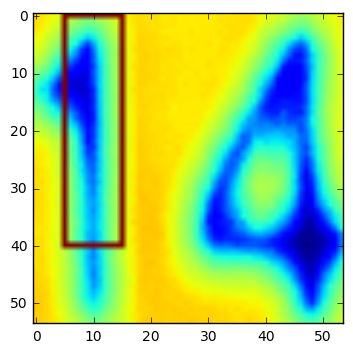

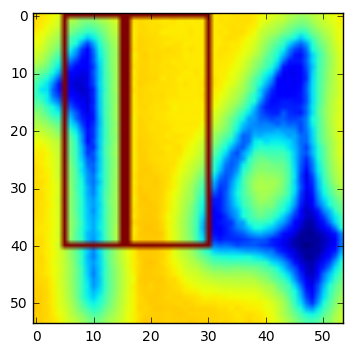

In [90]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
def draw_rectangle_on_image(pil_image, top, down, left, right):
    draw = ImageDraw.Draw(im)
    draw.line([(left, top),(right, top)], fill=255)
    draw.line([(left, bottom),(right, bottom)], fill=255)
    draw.line([(left, top),(left, bottom)], fill=255)
    draw.line([(right, top),(right, bottom)], fill=255)
    plt.imshow(im)
    plt.show()
    
im = Image.open("./captured_images/pic_14_resized.png")
draw_rectangle_on_image(im, d1_box[0], d1_box[1], d1_box[2], d1_box[3])
draw_rectangle_on_image(im, d2_box[0], d2_box[1], d2_box[2], d2_box[3])

### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

My model reduced the MSE error to

Using the results of this model as an input to a digit recognition model will help it improve the accuracy of predictions. However in my case the model is not producing relevant results. The results are not in the range of the normalized input. However the order is correct. i.e. first digit box before second digit box.

Theoretically, the model will work as follows:
* The image will be cropped based on the predicted bouding box
* Each digit of each image is then fed to its own softmax classifier to predict individual digits which reduces the complexity of the task fo predicting multiple digits together.

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

The average mean square error on the SVHN test dataset is 0.3172. On the 5 captured pictured the root MSE jumped to 28.658710

To illustrate I have drawn the bounding boxes on the "14" image I have captured. You can see that after the normalization the first digit is somehow in the predicted bouding box however, they second digit is totally out of the range. Thus our model is not accurately predicting bounding boxes and cannot be used to improve results of the original classification problem.

Similar to the classification problem, prediciting on newly captured images is a harder task due to the fact that images can be blurry and of different colors and fonts. The way I determined the bounding boxes could be a little different than the way the bounding boxes on the SVHN dataset has been produced. This could add some additional error. 

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.